# **VGG16: Image Modality for Informative Task**
Se usa la arquitectura de redes neuronales convolucionales desarrollada por la Universidad de Oxford.

In [2]:
import tensorflow as tf
import os

# FORZAR usar solo GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("✅ Usando solo GPU 0")
print("✅ GPUs visibles:", tf.config.list_physical_devices('GPU'))

✅ Usando solo GPU 0
✅ GPUs visibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from PIL import Image
import os

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### **Preprocesamiento de imágenes**
- Redimensionar y normalizar (224x224)
- Valores de los pixeles entre 0 y 1
- Normalizar los canales de color con respecto al dataset ImageNet

In [6]:
# Los datos ya fueron preprocesados y guardados como archivos .npy
# Falta cargar los datos
default_path = "/home/jacruz/crisis/data/preprocessed_images/"
df = pd.read_csv("/home/jacruz/crisis/data/crisis_images_dataset.csv")

image_names = df['image_name'].tolist()
labels = df['image_info'].tolist()

In [7]:
image_paths = [default_path + name + '.npy' for name in image_names]
image_paths[:5]

['/home/jacruz/crisis/data/preprocessed_images/917791044158185473_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791130590183424_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_1.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917792092100988929_0.npy']

In [8]:
image_path = image_paths[0]
if not os.path.exists(image_path):
                print(f"Archivo no encontrado: {image_path}")

In [9]:
def load_images_from_paths(image_paths, target_size=(224, 224)):
    """
    Carga imágenes desde rutas de archivo
    """
    images = []
    valid_indices = []
    
    print(f"Cargando {len(image_paths)} imágenes desde rutas...")
    
    for i, npy_path in enumerate(image_paths):
        try:
            # Verificar si el archivo existe
            if not os.path.exists(npy_path):
                print(f"Archivo no encontrado: {npy_path}")
                continue
                
            # Cargar array numpy
            img_array = np.load(npy_path)
            
            images.append(img_array)
            valid_indices.append(i)
            
        except Exception as e:
            print(f"Error cargando imagen {npy_path}: {e}")
            print(f"Forma del array: {img_array.shape}" if 'img_array' in locals() else "No se pudo cargar el array.")
            continue
            
        # Mostrar progreso cada 1000 imágenes
        if (i + 1) % 1000 == 0:
            print(f"Procesadas {i + 1}/{len(image_paths)} imágenes")
    
    print(f"Imágenes cargadas exitosamente: {len(images)}/{len(image_paths)}")
    
    return np.array(images), valid_indices

In [10]:

def load_and_prepare_data():
    """
    Carga los arrays numpy preprocesados (.npy) y prepara para entrenamiento
    """
    # Cargar los arrays
    X_paths = np.array(image_paths)
    y_labels = np.array(labels)
    
    # Verificar formas
    print(f"Número de rutas de imágenes: {len(X_paths)}")
    print(f"Número de etiquetas: {len(y_labels)}")

    # Cargar imágenes desde las rutas
    X_images, valid_indices = load_images_from_paths(X_paths)

    # Filtrar etiquetas para mantener solo las correspondientes a imágenes cargadas exitosamente
    y_labels_filtered = y_labels[valid_indices]
    
    # Mapeo manual de labels a números
    # Según el paper: 0 = Not-informative, 1 = Informative
    label_mapping = {'not_informative': 0, 'informative': 1}
    
    # Convertir etiquetas de texto a numéricas
    y_numeric = np.array([label_mapping[label] for label in y_labels_filtered])
    
    print(f"Distribución de etiquetas:")
    print(f"Non-informative (0): {np.sum(y_numeric == 0)}")
    print(f"Informative (1): {np.sum(y_numeric == 1)}")

    # Se asegura de tener el formato correcto
    X_images = X_images.astype('float32')

    y_categorical = to_categorical(y_numeric, num_classes=2)

    print(f"Rango de valores en X: min {X_images.min():.3f}, max {X_images.max():.3f}")

    print(f"Forma final de X: {X_images.shape}")
    print(f"Forma final de y: {y_categorical.shape}")
    return X_images, y_categorical

def split_data(X, y, test_size=0.3, val_size=0.5):
    """
    Divide los datos en train, validation y test y convierte a arrays numpy
    """
    X = np.array(X)
    y = np.array(y)

    print(f"Forma de X antes de split: {X.shape}")
    print(f"Forma de y antes de split: {y.shape}")

    # Primera división: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Segunda división: val vs test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )

    print(f"Formas después del split:")
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### **Arquitectura del modelo**
Se usa el modelo pre-entrenado VGG16 para aplicar transfer learning
- Se busca reutilizar los pesos
- Se reemplaza la última capa por _softmax_ 

In [11]:

def create_vgg16_model(num_classes=2, input_shape=(224, 224, 3)):
    """
    Crea el modelo VGG16 para clasificación binaria
    según la descripción del paper
    """
    # Cargar VGG16 pre-entrenado en ImageNet (sin la capa final)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Congelar las capas convolucionales (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Añadir capas personalizadas según el paper
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)  # Capa fc2 mencionada en el paper
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)  # Dropout rate usado en el paper
    
    # Capa de salida
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Modelo final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

### **Entrenamiento**
- Uso del Adam optimizer con initial learning rate de 10^-6
- Se reduce la tasa de aprendizaje en 0.1 si el accuracy deja de mejorar después de las 100 épocas
- El máximo de épocas es 1000, con early stopping

In [12]:
def setup_training(model):
    """
    Configura el optimizador y callbacks según el paper
    """
    # Optimizador Adam con learning rate muy bajo (1e-6) como en el paper
    optimizer = Adam(learning_rate=1e-6)
    
    # Callbacks
    callbacks = [
        # Early stopping con paciencia de 100 epochs (como en el paper)
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=100,
            restore_best_weights=True
        ),
        # ReduceLROnPlateau (mencionado en el paper)
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=50,
            min_lr=1e-8
        ),
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_vgg16_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        # CSV Logger para registrar el historial de entrenamiento
        tf.keras.callbacks.CSVLogger(
            'training_history.csv',
            separator=',',
            append=False
        )
    ]
    
    # Compilar modelo
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return callbacks

### **Evaluación del modelo**

In [13]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluación completa del modelo
    """
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, 
                              target_names=['Not-informative', 'Informative']))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not-inf', 'Inf'],
                yticklabels=['Not-inf', 'Inf'])
    plt.title('Matriz de Confusión - VGG16')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
    
    return y_pred_classes, y_true_classes

### **Curvas de aprendizaje**

In [14]:
def plot_learning_curves(history):
    """
    Grafica las curvas de aprendizaje a partir del historial de entrenamiento
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Curva de pérdida
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Pérdida durante el entrenamiento')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Curva de accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 1].set_title('Accuracy durante el entrenamiento')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Curva de precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Precision durante el entrenamiento')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Curva de recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Recall durante el entrenamiento')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # También graficar F1-score
    train_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(history.history['precision'], history.history['recall'])]
    val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(history.history['val_precision'], history.history['val_recall'])]
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_f1, label='Train F1-score')
    plt.plot(val_f1, label='Val F1-score')
    plt.title('F1-score durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid(True)
    plt.savefig('f1_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

### **Experimento**

Cargando datos...
Número de rutas de imágenes: 18082
Número de etiquetas: 18082
Cargando 18082 imágenes desde rutas...
Procesadas 1000/18082 imágenes
Procesadas 2000/18082 imágenes
Procesadas 3000/18082 imágenes
Procesadas 4000/18082 imágenes
Procesadas 5000/18082 imágenes
Procesadas 6000/18082 imágenes
Procesadas 7000/18082 imágenes
Procesadas 8000/18082 imágenes
Procesadas 9000/18082 imágenes
Procesadas 10000/18082 imágenes
Procesadas 11000/18082 imágenes
Procesadas 12000/18082 imágenes
Procesadas 13000/18082 imágenes
Procesadas 14000/18082 imágenes
Procesadas 15000/18082 imágenes
Procesadas 16000/18082 imágenes
Procesadas 17000/18082 imágenes
Procesadas 18000/18082 imágenes
Imágenes cargadas exitosamente: 18082/18082
Distribución de etiquetas:
Non-informative (0): 8708
Informative (1): 9374
Rango de valores en X: min -2.118, max 2.640
Forma final de X: (18082, 224, 224, 3)
Forma final de y: (18082, 2)
Dividiendo datos...
Forma de X antes de split: (18082, 224, 224, 3)
Forma de y ant

I0000 00:00:1764117359.283324  539304 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46874 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:05:00.0, compute capability: 8.6


Iniciando entrenamiento...


2025-11-25 21:36:01.173918: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.
2025-11-25 21:36:05.909651: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.


Epoch 1/100


2025-11-25 21:36:10.331707: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f40b0001f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-25 21:36:10.331726: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-25 21:36:10.371223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 21:36:10.599612: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-25 21:36:10.669827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 21:36:11.520900: I external

  3/396 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.3785 - loss: 1.3032 - precision: 0.3785 - recall: 0.3785

I0000 00:00:1764117374.912434  539768 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4044 - loss: 1.2189 - precision: 0.4044 - recall: 0.4044

2025-11-25 21:36:32.262363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 12 bytes spill stores, 12 bytes spill loads



396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4044 - loss: 1.2187 - precision: 0.4044 - recall: 0.4044

2025-11-25 21:36:41.999418: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_304', 12 bytes spill stores, 12 bytes spill loads



396/396 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.4213 - loss: 1.1393 - precision: 0.4213 - recall: 0.4213 - val_accuracy: 0.4639 - val_loss: 0.8456 - val_precision: 0.4639 - val_recall: 0.4639 - learning_rate: 1.0000e-06
Epoch 2/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4873 - loss: 0.9411 - precision: 0.4873 - recall: 0.4873

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.5043 - loss: 0.8982 - precision: 0.5043 - recall: 0.5043 - val_accuracy: 0.5546 - val_loss: 0.8110 - val_precision: 0.5546 - val_recall: 0.5546 - learning_rate: 1.0000e-06
Epoch 3/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5670 - loss: 0.7844 - precision: 0.5670 - recall: 0.5670

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5799 - loss: 0.7691 - precision: 0.5799 - recall: 0.5799 - val_accuracy: 0.6228 - val_loss: 0.7185 - val_precision: 0.6228 - val_recall: 0.6228 - learning_rate: 1.0000e-06
Epoch 4/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6190 - loss: 0.7127 - precision: 0.6190 - recall: 0.6190

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6302 - loss: 0.6956 - precision: 0.6302 - recall: 0.6302 - val_accuracy: 0.6574 - val_loss: 0.6624 - val_precision: 0.6574 - val_recall: 0.6574 - learning_rate: 1.0000e-06
Epoch 5/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6539 - loss: 0.6642 - precision: 0.6539 - recall: 0.6539

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6605 - loss: 0.6504 - precision: 0.6605 - recall: 0.6605 - val_accuracy: 0.6748 - val_loss: 0.6280 - val_precision: 0.6748 - val_recall: 0.6748 - learning_rate: 1.0000e-06
Epoch 6/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6760 - loss: 0.6322 - precision: 0.6760 - recall: 0.6760

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6776 - loss: 0.6264 - precision: 0.6776 - recall: 0.6776 - val_accuracy: 0.6910 - val_loss: 0.6034 - val_precision: 0.6910 - val_recall: 0.6910 - learning_rate: 1.0000e-06
Epoch 7/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6960 - loss: 0.6032 - precision: 0.6960 - recall: 0.6960

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6914 - loss: 0.6020 - precision: 0.6914 - recall: 0.6914 - val_accuracy: 0.7006 - val_loss: 0.5847 - val_precision: 0.7006 - val_recall: 0.7006 - learning_rate: 1.0000e-06
Epoch 8/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7014 - loss: 0.5850 - precision: 0.7014 - recall: 0.7014

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7030 - loss: 0.5885 - precision: 0.7030 - recall: 0.7030 - val_accuracy: 0.7069 - val_loss: 0.5712 - val_precision: 0.7069 - val_recall: 0.7069 - learning_rate: 1.0000e-06
Epoch 9/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7148 - loss: 0.5759 - precision: 0.7148 - recall: 0.7148

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7140 - loss: 0.5758 - precision: 0.7140 - recall: 0.7140 - val_accuracy: 0.7124 - val_loss: 0.5603 - val_precision: 0.7124 - val_recall: 0.7124 - learning_rate: 1.0000e-06
Epoch 10/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7202 - loss: 0.5600 - precision: 0.7202 - recall: 0.7202

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7151 - loss: 0.5657 - precision: 0.7151 - recall: 0.7151 - val_accuracy: 0.7179 - val_loss: 0.5503 - val_precision: 0.7179 - val_recall: 0.7179 - learning_rate: 1.0000e-06
Epoch 11/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7213 - loss: 0.5616 - precision: 0.7213 - recall: 0.7213

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7234 - loss: 0.5557 - precision: 0.7234 - recall: 0.7234 - val_accuracy: 0.7194 - val_loss: 0.5423 - val_precision: 0.7194 - val_recall: 0.7194 - learning_rate: 1.0000e-06
Epoch 12/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7289 - loss: 0.5504 - precision: 0.7289 - recall: 0.7289

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7300 - loss: 0.5501 - precision: 0.7300 - recall: 0.7300 - val_accuracy: 0.7260 - val_loss: 0.5351 - val_precision: 0.7260 - val_recall: 0.7260 - learning_rate: 1.0000e-06
Epoch 13/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7314 - loss: 0.5461 - precision: 0.7314 - recall: 0.7314

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7327 - loss: 0.5406 - precision: 0.7327 - recall: 0.7327 - val_accuracy: 0.7316 - val_loss: 0.5292 - val_precision: 0.7316 - val_recall: 0.7316 - learning_rate: 1.0000e-06
Epoch 14/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7382 - loss: 0.5261 - precision: 0.7382 - recall: 0.7382

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7314 - loss: 0.5346 - precision: 0.7314 - recall: 0.7314 - val_accuracy: 0.7356 - val_loss: 0.5236 - val_precision: 0.7356 - val_recall: 0.7356 - learning_rate: 1.0000e-06
Epoch 15/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7351 - loss: 0.5329 - precision: 0.7351 - recall: 0.7351

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7367 - loss: 0.5313 - precision: 0.7367 - recall: 0.7367 - val_accuracy: 0.7400 - val_loss: 0.5187 - val_precision: 0.7400 - val_recall: 0.7400 - learning_rate: 1.0000e-06
Epoch 16/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7344 - loss: 0.5313 - precision: 0.7344 - recall: 0.7344

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7418 - loss: 0.5270 - precision: 0.7418 - recall: 0.7418 - val_accuracy: 0.7426 - val_loss: 0.5144 - val_precision: 0.7426 - val_recall: 0.7426 - learning_rate: 1.0000e-06
Epoch 17/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7448 - loss: 0.5241 - precision: 0.7448 - recall: 0.7448

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7448 - loss: 0.5207 - precision: 0.7448 - recall: 0.7448 - val_accuracy: 0.7434 - val_loss: 0.5100 - val_precision: 0.7434 - val_recall: 0.7434 - learning_rate: 1.0000e-06
Epoch 18/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7428 - loss: 0.5236 - precision: 0.7428 - recall: 0.7428

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7474 - loss: 0.5178 - precision: 0.7474 - recall: 0.7474 - val_accuracy: 0.7478 - val_loss: 0.5072 - val_precision: 0.7478 - val_recall: 0.7478 - learning_rate: 1.0000e-06
Epoch 19/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7465 - loss: 0.5146 - precision: 0.7465 - recall: 0.7465 - val_accuracy: 0.7467 - val_loss: 0.5040 - val_precision: 0.7467 - val_recall: 0.7467 - learning_rate: 1.0000e-06
Epoch 20/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7597 - loss: 0.5039 - precision: 0.7597 - recall: 0.7597

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7565 - loss: 0.5100 - precision: 0.7565 - recall: 0.7565 - val_accuracy: 0.7526 - val_loss: 0.5006 - val_precision: 0.7526 - val_recall: 0.7526 - learning_rate: 1.0000e-06
Epoch 21/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7480 - loss: 0.5161 - precision: 0.7480 - recall: 0.7480

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7506 - loss: 0.5127 - precision: 0.7506 - recall: 0.7506 - val_accuracy: 0.7548 - val_loss: 0.4980 - val_precision: 0.7548 - val_recall: 0.7548 - learning_rate: 1.0000e-06
Epoch 22/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7588 - loss: 0.5019 - precision: 0.7588 - recall: 0.7588

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7563 - loss: 0.5043 - precision: 0.7563 - recall: 0.7563 - val_accuracy: 0.7574 - val_loss: 0.4955 - val_precision: 0.7574 - val_recall: 0.7574 - learning_rate: 1.0000e-06
Epoch 23/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7556 - loss: 0.5003 - precision: 0.7556 - recall: 0.7556 - val_accuracy: 0.7574 - val_loss: 0.4934 - val_precision: 0.7574 - val_recall: 0.7574 - learning_rate: 1.0000e-06
Epoch 24/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7580 - loss: 0.4995 - precision: 0.7580 - recall: 0.7580 - val_accuracy: 0.7570 - val_loss: 0.4909 - val_precision: 0.7570 - val_recall: 0.7570 - learning_rate: 1.0000e-06
Epoch 25/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7635 - loss: 0.4914 - precision: 0.7635 - recall: 0.7635

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7580 - loss: 0.4980 - precision: 0.7580 - recall: 0.7580 - val_accuracy: 0.7577 - val_loss: 0.4893 - val_precision: 0.7577 - val_recall: 0.7577 - learning_rate: 1.0000e-06
Epoch 26/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7558 - loss: 0.5037 - precision: 0.7558 - recall: 0.7558

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7621 - loss: 0.4943 - precision: 0.7621 - recall: 0.7621 - val_accuracy: 0.7585 - val_loss: 0.4875 - val_precision: 0.7585 - val_recall: 0.7585 - learning_rate: 1.0000e-06
Epoch 27/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7667 - loss: 0.4879 - precision: 0.7667 - recall: 0.7667

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7638 - loss: 0.4919 - precision: 0.7638 - recall: 0.7638 - val_accuracy: 0.7603 - val_loss: 0.4852 - val_precision: 0.7603 - val_recall: 0.7603 - learning_rate: 1.0000e-06
Epoch 28/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7610 - loss: 0.5003 - precision: 0.7610 - recall: 0.7610

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7625 - loss: 0.4926 - precision: 0.7625 - recall: 0.7625 - val_accuracy: 0.7622 - val_loss: 0.4838 - val_precision: 0.7622 - val_recall: 0.7622 - learning_rate: 1.0000e-06
Epoch 29/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7563 - loss: 0.4978 - precision: 0.7563 - recall: 0.7563

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7625 - loss: 0.4906 - precision: 0.7625 - recall: 0.7625 - val_accuracy: 0.7644 - val_loss: 0.4822 - val_precision: 0.7644 - val_recall: 0.7644 - learning_rate: 1.0000e-06
Epoch 30/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7656 - loss: 0.4940 - precision: 0.7656 - recall: 0.7656

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7683 - loss: 0.4873 - precision: 0.7683 - recall: 0.7683 - val_accuracy: 0.7677 - val_loss: 0.4807 - val_precision: 0.7677 - val_recall: 0.7677 - learning_rate: 1.0000e-06
Epoch 31/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7642 - loss: 0.4863 - precision: 0.7642 - recall: 0.7642 - val_accuracy: 0.7662 - val_loss: 0.4795 - val_precision: 0.7662 - val_recall: 0.7662 - learning_rate: 1.0000e-06
Epoch 32/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7677 - loss: 0.4806 - precision: 0.7677 - recall: 0.7677 - val_accuracy: 0.7677 - val_loss: 0.4784 - val_precision: 0.7677 - val_recall: 0.7677 - learning_rate: 1.0000e-06
Epoch 33/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7583 - loss: 0.4935 - precision: 0.7583 - recall: 0.7583

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7691 - loss: 0.4828 - precision: 0.7691 - recall: 0.7691 - val_accuracy: 0.7681 - val_loss: 0.4768 - val_precision: 0.7681 - val_recall: 0.7681 - learning_rate: 1.0000e-06
Epoch 34/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7797 - loss: 0.4703 - precision: 0.7797 - recall: 0.7797

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7741 - loss: 0.4786 - precision: 0.7741 - recall: 0.7741 - val_accuracy: 0.7703 - val_loss: 0.4758 - val_precision: 0.7703 - val_recall: 0.7703 - learning_rate: 1.0000e-06
Epoch 35/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7704 - loss: 0.4797 - precision: 0.7704 - recall: 0.7704 - val_accuracy: 0.7695 - val_loss: 0.4753 - val_precision: 0.7695 - val_recall: 0.7695 - learning_rate: 1.0000e-06
Epoch 36/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7715 - loss: 0.4722 - precision: 0.7715 - recall: 0.7715

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7714 - loss: 0.4757 - precision: 0.7714 - recall: 0.7714 - val_accuracy: 0.7725 - val_loss: 0.4733 - val_precision: 0.7725 - val_recall: 0.7725 - learning_rate: 1.0000e-06
Epoch 37/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7783 - loss: 0.4670 - precision: 0.7783 - recall: 0.7783

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7745 - loss: 0.4759 - precision: 0.7745 - recall: 0.7745 - val_accuracy: 0.7732 - val_loss: 0.4725 - val_precision: 0.7732 - val_recall: 0.7732 - learning_rate: 1.0000e-06
Epoch 38/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7753 - loss: 0.4730 - precision: 0.7753 - recall: 0.7753 - val_accuracy: 0.7732 - val_loss: 0.4716 - val_precision: 0.7732 - val_recall: 0.7732 - learning_rate: 1.0000e-06
Epoch 39/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7740 - loss: 0.4739 - precision: 0.7740 - recall: 0.7740 - val_accuracy: 0.7732 - val_loss: 0.4704 - val_precision: 0.7732 - val_recall: 0.7732 - learning_rate: 1.0000e-06
Epoch 40/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7717 - loss: 0.4722 - precision: 0.7717 - recall: 0.7717

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7776 - loss: 0.4700 - precision: 0.7776 - recall: 0.7776 - val_accuracy: 0.7777 - val_loss: 0.4696 - val_precision: 0.7777 - val_recall: 0.7777 - learning_rate: 1.0000e-06
Epoch 41/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7785 - loss: 0.4702 - precision: 0.7785 - recall: 0.7785 - val_accuracy: 0.7773 - val_loss: 0.4685 - val_precision: 0.7773 - val_recall: 0.7773 - learning_rate: 1.0000e-06
Epoch 42/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7849 - loss: 0.4628 - precision: 0.7849 - recall: 0.7849

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7762 - loss: 0.4695 - precision: 0.7762 - recall: 0.7762 - val_accuracy: 0.7780 - val_loss: 0.4677 - val_precision: 0.7780 - val_recall: 0.7780 - learning_rate: 1.0000e-06
Epoch 43/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7790 - loss: 0.4663 - precision: 0.7790 - recall: 0.7790 - val_accuracy: 0.7777 - val_loss: 0.4669 - val_precision: 0.7777 - val_recall: 0.7777 - learning_rate: 1.0000e-06
Epoch 44/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7778 - loss: 0.4636 - precision: 0.7778 - recall: 0.7778

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7824 - loss: 0.4607 - precision: 0.7824 - recall: 0.7824 - val_accuracy: 0.7791 - val_loss: 0.4663 - val_precision: 0.7791 - val_recall: 0.7791 - learning_rate: 1.0000e-06
Epoch 45/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7851 - loss: 0.4583 - precision: 0.7851 - recall: 0.7851

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7819 - loss: 0.4614 - precision: 0.7819 - recall: 0.7819 - val_accuracy: 0.7799 - val_loss: 0.4661 - val_precision: 0.7799 - val_recall: 0.7799 - learning_rate: 1.0000e-06
Epoch 46/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7818 - loss: 0.4624 - precision: 0.7818 - recall: 0.7818

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7826 - loss: 0.4625 - precision: 0.7826 - recall: 0.7826 - val_accuracy: 0.7810 - val_loss: 0.4646 - val_precision: 0.7810 - val_recall: 0.7810 - learning_rate: 1.0000e-06
Epoch 47/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7792 - loss: 0.4608 - precision: 0.7792 - recall: 0.7792 - val_accuracy: 0.7802 - val_loss: 0.4641 - val_precision: 0.7802 - val_recall: 0.7802 - learning_rate: 1.0000e-06
Epoch 48/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7826 - loss: 0.4610 - precision: 0.7826 - recall: 0.7826 - val_accuracy: 0.7806 - val_loss: 0.4634 - val_precision: 0.7806 - val_recall: 0.7806 - learning_rate: 1.0000e-06
Epoch 49/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7852 - loss: 0.4540 - precision: 0.7852 - recall: 0.7852

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7818 - loss: 0.4581 - precision: 0.7818 - recall: 0.7818 - val_accuracy: 0.7813 - val_loss: 0.4627 - val_precision: 0.7813 - val_recall: 0.7813 - learning_rate: 1.0000e-06
Epoch 50/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7859 - loss: 0.4569 - precision: 0.7859 - recall: 0.7859 - val_accuracy: 0.7810 - val_loss: 0.4624 - val_precision: 0.7810 - val_recall: 0.7810 - learning_rate: 1.0000e-06
Epoch 51/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7864 - loss: 0.4534 - precision: 0.7864 - recall: 0.7864 - val_accuracy: 0.7802 - val_loss: 0.4617 - val_precision: 0.7802 - val_recall: 0.7802 - learning_rate: 1.0000e-06
Epoch 52/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7807 - loss: 0.4634 - precision: 0.7807 - recall: 0.7807

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7826 - loss: 0.4583 - precision: 0.7826 - recall: 0.7826 - val_accuracy: 0.7817 - val_loss: 0.4608 - val_precision: 0.7817 - val_recall: 0.7817 - learning_rate: 1.0000e-06
Epoch 53/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7892 - loss: 0.4539 - precision: 0.7892 - recall: 0.7892

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7852 - loss: 0.4541 - precision: 0.7852 - recall: 0.7852 - val_accuracy: 0.7821 - val_loss: 0.4604 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 1.0000e-06
Epoch 54/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7779 - loss: 0.4587 - precision: 0.7779 - recall: 0.7779

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7824 - loss: 0.4550 - precision: 0.7824 - recall: 0.7824 - val_accuracy: 0.7824 - val_loss: 0.4597 - val_precision: 0.7824 - val_recall: 0.7824 - learning_rate: 1.0000e-06
Epoch 55/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7894 - loss: 0.4444 - precision: 0.7894 - recall: 0.7894

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7849 - loss: 0.4531 - precision: 0.7849 - recall: 0.7849 - val_accuracy: 0.7843 - val_loss: 0.4590 - val_precision: 0.7843 - val_recall: 0.7843 - learning_rate: 1.0000e-06
Epoch 56/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7879 - loss: 0.4526 - precision: 0.7879 - recall: 0.7879 - val_accuracy: 0.7832 - val_loss: 0.4586 - val_precision: 0.7832 - val_recall: 0.7832 - learning_rate: 1.0000e-06
Epoch 57/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7940 - loss: 0.4402 - precision: 0.7940 - recall: 0.7940

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7870 - loss: 0.4522 - precision: 0.7870 - recall: 0.7870 - val_accuracy: 0.7850 - val_loss: 0.4579 - val_precision: 0.7850 - val_recall: 0.7850 - learning_rate: 1.0000e-06
Epoch 58/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7874 - loss: 0.4514 - precision: 0.7874 - recall: 0.7874 - val_accuracy: 0.7839 - val_loss: 0.4577 - val_precision: 0.7839 - val_recall: 0.7839 - learning_rate: 1.0000e-06
Epoch 59/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7895 - loss: 0.4421 - precision: 0.7895 - recall: 0.7895

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7898 - loss: 0.4462 - precision: 0.7898 - recall: 0.7898 - val_accuracy: 0.7883 - val_loss: 0.4569 - val_precision: 0.7883 - val_recall: 0.7883 - learning_rate: 1.0000e-06
Epoch 60/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7901 - loss: 0.4479 - precision: 0.7901 - recall: 0.7901 - val_accuracy: 0.7839 - val_loss: 0.4569 - val_precision: 0.7839 - val_recall: 0.7839 - learning_rate: 1.0000e-06
Epoch 61/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7898 - loss: 0.4513 - precision: 0.7898 - recall: 0.7898

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7883 - loss: 0.4511 - precision: 0.7883 - recall: 0.7883 - val_accuracy: 0.7906 - val_loss: 0.4559 - val_precision: 0.7906 - val_recall: 0.7906 - learning_rate: 1.0000e-06
Epoch 62/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7932 - loss: 0.4430 - precision: 0.7932 - recall: 0.7932 - val_accuracy: 0.7872 - val_loss: 0.4556 - val_precision: 0.7872 - val_recall: 0.7872 - learning_rate: 1.0000e-06
Epoch 63/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7914 - loss: 0.4462 - precision: 0.7914 - recall: 0.7914 - val_accuracy: 0.7883 - val_loss: 0.4552 - val_precision: 0.7883 - val_recall: 0.7883 - learning_rate: 1.0000e-06
Epoch 64/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7941 - loss: 0.4450 - precision: 0.7941 - recall: 0.7941 - val_accuracy: 0.7858 - val_loss: 0.4548 - val_precision: 0.7858 - val_recall: 0.7858 - learning_rate: 1.0000e-06
Epoch 65/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8013 - loss: 0.4238 - precision: 0.8013 - recall: 0.8013 - val_accuracy: 0.7909 - val_loss: 0.4449 - val_precision: 0.7909 - val_recall: 0.7909 - learning_rate: 1.0000e-06
Epoch 97/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8049 - loss: 0.4245 - precision: 0.8049 - recall: 0.8049 - val_accuracy: 0.7895 - val_loss: 0.4444 - val_precision: 0.7895 - val_recall: 0.7895 - learning_rate: 1.0000e-06
Epoch 98/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8039 - loss: 0.4194 - precision: 0.8039 - recall: 0.8039

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8058 - loss: 0.4212 - precision: 0.8058 - recall: 0.8058 - val_accuracy: 0.7913 - val_loss: 0.4442 - val_precision: 0.7913 - val_recall: 0.7913 - learning_rate: 1.0000e-06
Epoch 99/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8063 - loss: 0.4197 - precision: 0.8063 - recall: 0.8063 - val_accuracy: 0.7898 - val_loss: 0.4439 - val_precision: 0.7898 - val_recall: 0.7898 - learning_rate: 1.0000e-06
Epoch 100/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8047 - loss: 0.4207 - precision: 0.8047 - recall: 0.8047

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8048 - loss: 0.4195 - precision: 0.8048 - recall: 0.8048 - val_accuracy: 0.7917 - val_loss: 0.4436 - val_precision: 0.7917 - val_recall: 0.7917 - learning_rate: 1.0000e-06

Graficando curvas de aprendizaje...


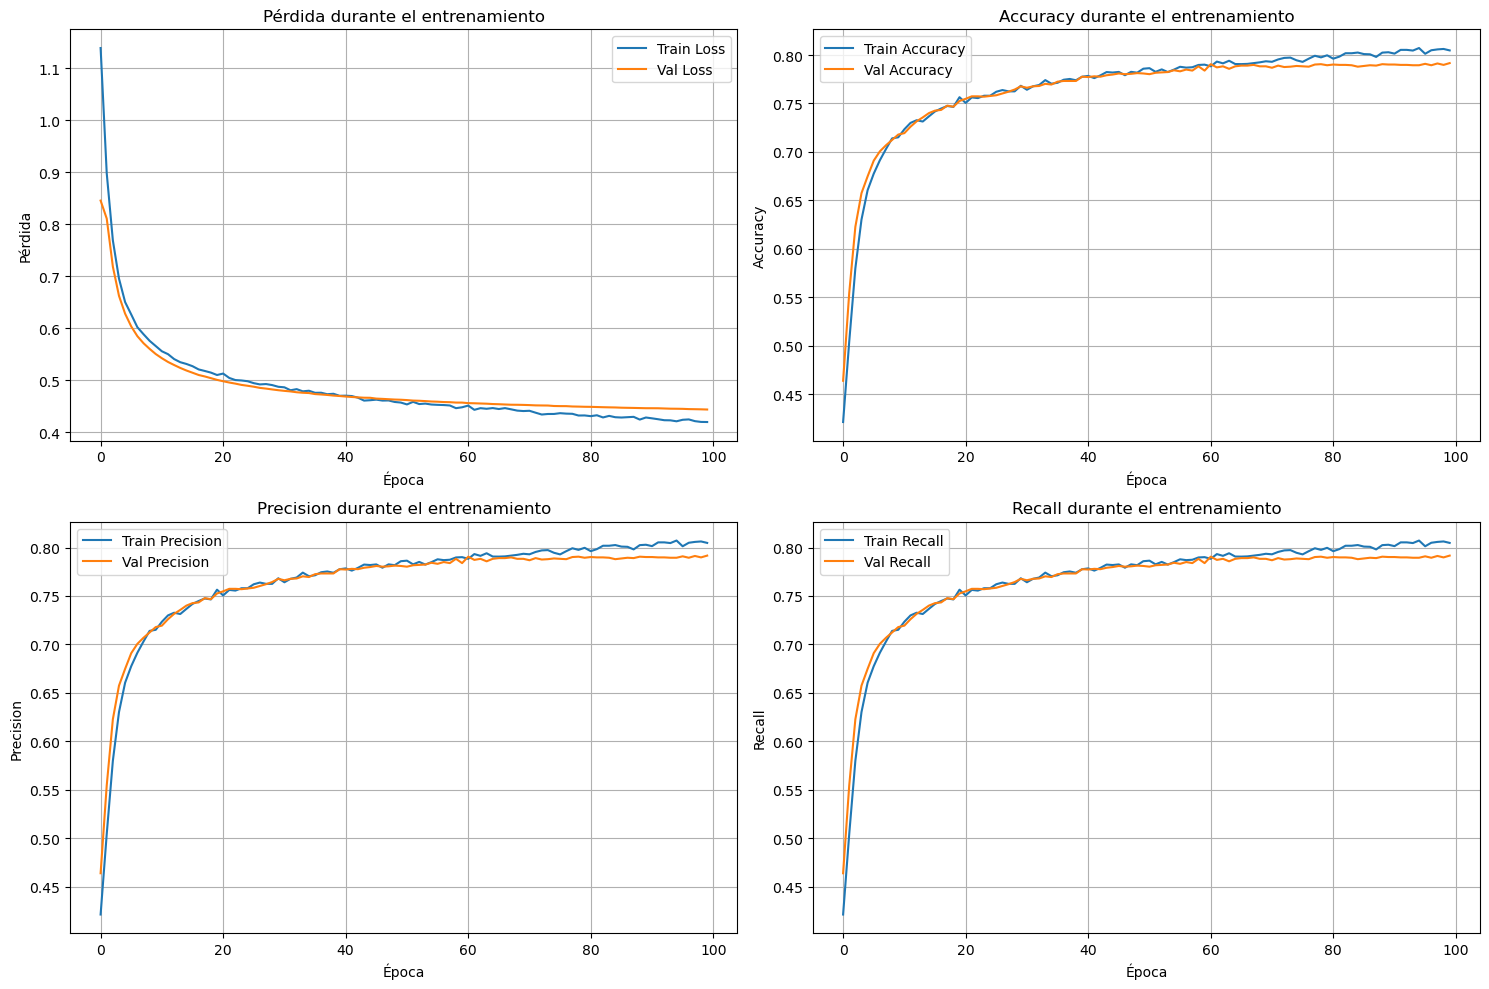

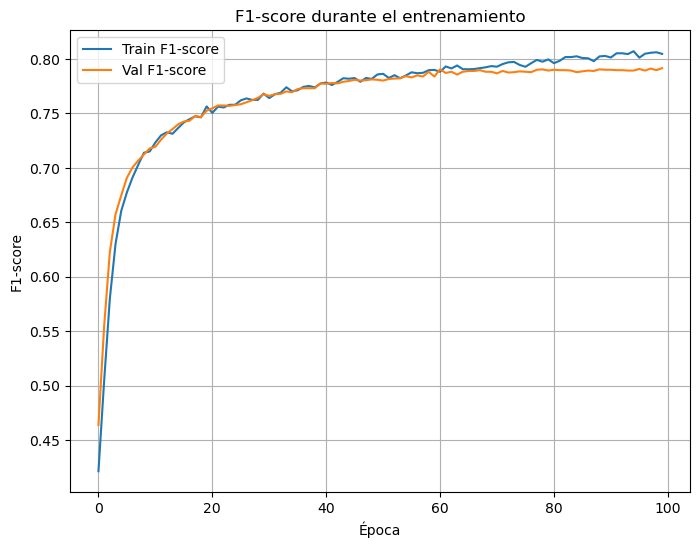

Evaluando en test set...


2025-11-25 22:11:33.242321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_304', 12 bytes spill stores, 12 bytes spill loads




=== RESULTADOS FINALES ===
Test Loss: 0.4515
Test Accuracy: 0.7870
Test Precision: 0.7870
Test Recall: 0.7870
Test F1-score: 0.7870
Cargando datos...
Número de rutas de imágenes: 18082
Número de etiquetas: 18082
Cargando 18082 imágenes desde rutas...
Procesadas 1000/18082 imágenes
Procesadas 2000/18082 imágenes
Procesadas 3000/18082 imágenes
Procesadas 4000/18082 imágenes
Procesadas 5000/18082 imágenes
Procesadas 6000/18082 imágenes
Procesadas 7000/18082 imágenes
Procesadas 8000/18082 imágenes
Procesadas 9000/18082 imágenes
Procesadas 10000/18082 imágenes
Procesadas 11000/18082 imágenes
Procesadas 12000/18082 imágenes
Procesadas 13000/18082 imágenes
Procesadas 14000/18082 imágenes
Procesadas 15000/18082 imágenes
Procesadas 16000/18082 imágenes
Procesadas 17000/18082 imágenes
Procesadas 18000/18082 imágenes
Imágenes cargadas exitosamente: 18082/18082
Distribución de etiquetas:
Non-informative (0): 8708
Informative (1): 9374
Rango de valores en X: min -2.118, max 2.640
Forma final de X:

2025-11-25 22:12:43.279350: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.
2025-11-25 22:12:48.089607: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.


Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5249 - loss: 0.8607 - precision: 0.5249 - recall: 0.5249

396/396 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.5527 - loss: 0.8131 - precision: 0.5527 - recall: 0.5527 - val_accuracy: 0.6180 - val_loss: 0.6662 - val_precision: 0.6180 - val_recall: 0.6180 - learning_rate: 1.0000e-06
Epoch 2/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6046 - loss: 0.7307 - precision: 0.6046 - recall: 0.6046

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6170 - loss: 0.7063 - precision: 0.6170 - recall: 0.6170 - val_accuracy: 0.6534 - val_loss: 0.6579 - val_precision: 0.6534 - val_recall: 0.6534 - learning_rate: 1.0000e-06
Epoch 3/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6459 - loss: 0.6674 - precision: 0.6459 - recall: 0.6459

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6566 - loss: 0.6500 - precision: 0.6566 - recall: 0.6566 - val_accuracy: 0.6763 - val_loss: 0.6228 - val_precision: 0.6763 - val_recall: 0.6763 - learning_rate: 1.0000e-06
Epoch 4/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6731 - loss: 0.6264 - precision: 0.6731 - recall: 0.6731

KeyboardInterrupt: 

In [ ]:
# 1. Cargar y preparar datos
print("Cargando datos...")
X, y = load_and_prepare_data()

print("Dividiendo datos...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")
    
# 3. Crear modelo
print("Creando modelo VGG16...")
model = create_vgg16_model(num_classes=2)

# 4. Configurar entrenamiento
callbacks = setup_training(model)

# 5. Entrenar modelo
print("Iniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    batch_size=32,  # Minibatch size del paper
    epochs=100,    # Máximo de epochs del paper
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# 6. Graficar curvas de aprendizaje
print("\nGraficando curvas de aprendizaje...")
plot_learning_curves(history)

# 7. Evaluar en test
print("Evaluando en test set...")
test_results = model.evaluate(X_test, y_test, verbose=0)

print("\n=== RESULTADOS FINALES ===")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

# Calcular F1-score
precision = test_results[2]
recall = test_results[3]
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Test F1-score: {f1:.4f}")

# Guardar el modelo
model.save('vgg16_binary.keras')
np.save('class_names.npy', ['not_informative', 'informative'])
print("Modelo y mapeo de clases guardados")

In [ ]:
model.save('vgg16_binary.keras')
np.save('class_names.npy', ['not_informative', 'informative'])
print("Modelo y mapeo de clases guardados")

Modelo y mapeo de clases guardados


: 